# Jester Recommendations System - Personalized Page Rank

https://www.kaggle.com/c/jesterdsub2019

*Alex Castrelo, Gerard Marrugat, Eduard Ribas, Pilar Santolaria*

## Imports and functions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import datetime
import os
import sys
import random

In [2]:
try: # if running on COLAB
    
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/My Drive/MDS/jester_jokes/'
    
except:
    PATH = os.getcwd() + '/'

In [4]:
PATH_LIB = PATH + "library/"
PATH_DATA = PATH + "data/"
PATH_BATCHES = PATH + 'batches/'
PATH_SUBMISSIONS = PATH + "submissions/"

sys.path.append(PATH_LIB)

print("Folders content:")
print("PATH:\t\t", os.listdir(PATH))
print("PATH LIBRARY:\t", os.listdir(PATH_LIB))
print("PATH DATA:\t", os.listdir(PATH_DATA))
print("PATH BATCHES:\t", os.listdir(PATH_BATCHES))
print("PATH SUBM.:\t", os.listdir(PATH_SUBMISSIONS))

Folders content:
PATH:		 ['.DS_Store', '.git', '.gitignore', '.ipynb_checkpoints', 'batches', 'data', 'ItemBasedCollaborativeFiltering.ipynb', 'library', 'LICENSE', 'mess_around_alex.ipynb', 'mess_around_edu.ipynb', 'mess_around_gerard.ipynb', 'mess_around_pilar.ipynb', 'notebooks', 'PersonalizedPageRank.ipynb', 'README.md', 'submissions']
PATH LIBRARY:	 ['.DS_Store', '__init__.py', '__pycache__', 'functions.py']
PATH DATA:	 ['.DS_Store', 'jokes', 'submision_sample.csv', 'target_user_items.csv', 'training.csv']
PATH BATCHES:	 ['.DS_Store', 'train_1000', 'train_100000', 'train_500000', 'train_full', 'train_IBCF']
PATH SUBM.:	 ['.DS_Store', 'submission_2019.03.28_15.53.csv', 'submission_2019.05.22_20.51.csv', 'submission_2019.05.23_20.00.csv', 'submission_2019.05.23_20.05.csv', 'submission_2019.05.24_16.44.csv', 'submission_2019.05.24_21.06.csv', 'submission_2019.05.25_16.14.csv', 'submission_2019.05.25_21.31.csv', 'submission_2019.05.27_19.58.csv', 'submission_2019.05.29_18.28.csv']


In [4]:
%load_ext autoreload
%autoreload 2
from functions import *

In [5]:
print_time("hi")

 2019-05-29 17:29:04.01 hi


## Parameters

In [5]:
TRAIN_SIZE = 5000000

## Train

### Load train data

In [7]:
%%time
df_train_full = load_df(PATH_DATA + "training.csv", 
                        #sort=True,
                        item_shift=True, 
                        rating_shift=True, 
                        #rating_normalize=True
)

CPU times: user 607 ms, sys: 106 ms, total: 713 ms
Wall time: 734 ms


### Prepare train set

In [8]:
%%time
if TRAIN_SIZE < df_train_full.shape[0]:
    print_time("training with " + str(TRAIN_SIZE) + " samples")
    train_idx = random.sample(range(df_train_full.shape[0]), TRAIN_SIZE)
    df_train = df_train_full.iloc[train_idx].copy()
else:
    TRAIN_SIZE = 'full'
    print_time("training with FULL train set")
    df_train = df_train_full.copy()

 2019-05-29 17:29:15.04 training with FULL train set
CPU times: user 7.61 ms, sys: 6.03 ms, total: 13.6 ms
Wall time: 11.1 ms


In [9]:
n_users = len(df_train.user_id.unique())
max_user_id = df_train.user_id.max()
print("There are", n_users, "users with max id", max_user_id, "( shift of", max_user_id-n_users, ")")

There are 73339 users with max id 73420 ( shift of 81 )


In [10]:
print(df_train.shape)
df_train.head(10)

(950000, 3)


,user_id,item_id,rating
0,13291,97,0.471480
1,19559,7,0.576820
2,32928,49,0.590587
3,34459,28,0.005000
4,68339,18,0.718899
5,7685,10,0.877087
6,28723,51,0.558831
7,31302,10,0.686949
8,39332,67,0.595812
9,8700,53,0.852941


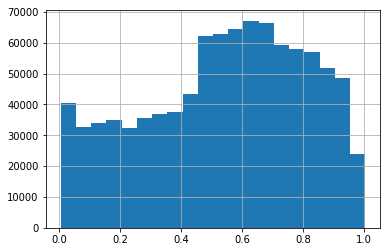

In [11]:
df_train["rating"].hist(
    bins = 20
)

In [12]:
mask = df_train["user_id"] == 2
df_train[mask]

,user_id,item_id,rating
264577,2,49,0.851516
378334,2,65,0.879987
572914,2,89,0.901157
586432,2,13,0.790793
835017,2,64,0.823997
864083,2,10,0.863753


## PPR approach

In [13]:
%%time
df_train_ui, UI_cs, UI_T_cs, id2idx, idx2id, n_users, n_items, N = build_PPR_components(df_train)

CPU times: user 5.99 s, sys: 437 ms, total: 6.43 s
Wall time: 6.82 s


In [14]:
print("DF shape:", df_train_ui.shape)
df_train_ui.head()

DF shape: (73339, 101)


item_id,user_id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
user_index,,,,,,,,,,,,,,,,,,,,,
0,0,0.000000,0.0,0.009357,0.0000,0.000000,0.08205,0.017306,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,1,0.000000,0.0,0.779457,0.7244,0.000000,0.00000,0.000000,0.000000,0.946676,...,0.0,0.0,0.517259,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
2,2,0.000000,0.0,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
3,3,0.000000,0.0,0.000000,0.0000,0.000000,0.00000,0.000000,0.828177,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,4,0.948335,0.0,0.299907,0.0000,0.547696,0.00000,0.000000,0.699735,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.64846,0.0,0.574051,0.0


### Prediction - PPR

In [17]:
def Power_Method(A, A_T, s, n, MAX_ITER=100, tol=1e-10, m=0.15, printDetails=False):
    
    if printDetails:
        print("starting iterations...")
    iterations = 0
    
    x0 = np.ones((n,1))
    x0 = x0/(np.linalg.norm(x0,2))

    while True:
        iterations += 1
        if printDetails and iterations % 10 == 0:
            print(" ", iterations)
            
        x1 = (1-m) * A @ ( (1-m) * A_T @ x0 + m * s )
        x1 = x1/(np.linalg.norm(x1,2)) 
        diff = np.linalg.norm(x1-x0, np.inf)
        x0 = x1
        
        if diff < tol:
            if printDetails:
                print("Converged!")
            break
            
        if iterations >= MAX_ITER:
            if printDetails:
                print("Did not converge!")
            break     
        
    return x0

def get_similar_users_idx(similarity_vec, num=100):
    top_sim_usr_idx = similarity_vec.argsort()[-num:][::-1]
    return top_sim_usr_idx

def predict_rating(user_id, item_id_list):
    DUMMY_RATING = 0.6
    MAX_SIM_RATINGS = 10
    
    if df_train_ui[df_train_ui.user_id==user_id].shape[0] == 0:
        return [DUMMY_RATING for item in item_id_list]
    
    # get items rated by user_id and build restart vector
    restart_vec = UI_T_cs[:,id2idx[user_id]].reshape(-1,1)
    restart_vec = np.array([1/N if el!=0 else 0 for el in list(restart_vec)]).reshape(-1,1)
    
    # solve PM
    sim_vec = Power_Method(UI_cs, UI_T_cs, restart_vec, n_users, MAX_ITER=100, tol=1e-10, m=0.15, printDetails=False)
    sim_vec = sim_vec.flatten()
    
    # get similar users index
    sim_users_idx = get_similar_users_idx(sim_vec)
    #print("sim_users_idx[:100]:",sim_users_idx[:100])
    
    # predict rating for each item
    predicted_ratings = []
    for item_id in item_id_list:
        #print("\nitem", item_id)
        pred_rating = 0
        weight = 0
        sim_users_count = 0
        for i, user_idx in enumerate(sim_users_idx):
            rating = df_train_ui.loc[user_idx, item_id]
            if rating > 0:
                sim_users_count += 1
                #print(sim_users_count, "similar user", user_idx, ", similarity", sim_vec[user_idx], ", rating", rating)
                pred_rating += rating*sim_vec[user_idx]
                weight += sim_vec[user_idx]
                if sim_users_count >= MAX_SIM_RATINGS:
                    break
        
        if weight > 0:
            pred_rating = pred_rating/weight
        else:
            pred_rating = DUMMY_RATING
        predicted_ratings.append(pred_rating)                                   
        
    return predicted_ratings

In [18]:
# predictions for a given user and some items
user_id = 6
items_id = [x for x in range(10)]
predicted_ratings = predict_rating(user_id,items_id)
print(predicted_ratings)
print("Done")

[0.8126070207827988, 0.7305953003927745, 0.8504695000518757, 0.6693987331308708, 0.6105821894384088, 0.8774475283781311, 0.7144866724869302, 0.7208267853467749, 0.8219419564111285, 0.815194076972458]
Done


## Test

### Load Test data

In [20]:
df_test = load_df(
    PATH_DATA + "target_user_items.csv", 
    item_shift=True, 
    #sort=True
)
#df_test.rename(columns="Unnamed: 0", inplace=True)
df_test.rename(index=str, columns={"Unnamed: 0": "id"}, inplace=True)
print(df_test.shape)
df_test.head(10)

(50000, 3)


,id,user_id,item_id
0,0,52841,67
1,1,51916,83
2,2,46765,64
3,3,9882,34
4,4,22323,23
5,5,40625,86
6,6,6051,33
7,7,40625,51
8,8,23789,37
9,9,19286,82


In [21]:
len(df_test.user_id.unique())

34090

### Prediction

In [22]:
def predict_PPR(row):
    if row["id"] % 500 == 0:
        print_time("\tpredicting row " + str(row["id"]))
    #return PPR(A_sparse, df_train, row["user_id"], row["item_id"])
    return predict_rating(row["user_id"], [row["item_id"]])[0]

#### Batch predict

In [23]:
batch_size = 10000
batches = np.arange(batch_size,df_test.shape[0]+1,batch_size)
print(batches)

[10000 20000 30000 40000 50000]


In [ ]:
BATCH_FOLDER = PATH_BATCHES + "train_" + str(TRAIN_SIZE) + "/"
create_directory(BATCH_FOLDER)

##### Predict for each batch and save

In [25]:
for batch in batches:
    filename =  "batch_" + str(batch) + ".csv"
    if filename not in os.listdir(BATCH_FOLDER):
        print_time("computing batch " + str(batch) + ": " + filename)
        df_test_batch = df_test.iloc[batch-batch_size:batch].copy()
        df_test_batch['rating_nr'] = df_test_batch.apply(predict_PPR, axis=1)
        df_test_batch.to_csv(BATCH_FOLDER + filename, index=False)
    else:
        print_time("batch " + str(batch) + " already exists!")

 2019-05-29 17:32:54.65 batch 10000 already exists!
 2019-05-29 17:32:54.65 batch 20000 already exists!
 2019-05-29 17:32:54.65 batch 30000 already exists!
 2019-05-29 17:32:54.65 batch 40000 already exists!
 2019-05-29 17:32:54.65 batch 50000 already exists!


##### Load prediction files in a single DF

In [26]:
df_test = pd.DataFrame(columns = ['id','user_id','item_id','rating_nr'])
for batch in batches:
    filename = "batch_" + str(batch) + ".csv"
    if filename in os.listdir(BATCH_FOLDER):
        print_time("reading batch file " + filename)
        df_test_batch = pd.read_csv(BATCH_FOLDER + filename)
        df_test = df_test.append(df_test_batch)
    else:
        print_time("batch file " + filename + " doesn't exist!")

 2019-05-29 17:32:59.51 reading batch file batch_10000.csv
 2019-05-29 17:32:59.53 reading batch file batch_20000.csv
 2019-05-29 17:32:59.54 reading batch file batch_30000.csv
 2019-05-29 17:32:59.56 reading batch file batch_40000.csv
 2019-05-29 17:32:59.58 reading batch file batch_50000.csv


#### Full predict

In [29]:
#%%time
#df_test['rating_nr'] = df_test.apply(predict_PPR, axis=1)

## Submission

In [31]:
df_test['rating'] = df_test['rating_nr']*20 - 10.1
df_test["item_id"] = df_test["item_id"]+1

In [89]:
subm_file = save_submission_file(df_test, PATH_SUBMISSIONS)

Dataframe saved: submission_2019.05.27_19.58.csv



https://www.kaggle.com/c/jesterdsub2019/submissions